## Part 1: Understanding Fine-Tuning

### What is Fine-Tuning?

Fine-tuning is like taking a graduate (pre-trained model) and giving them specialized training for your specific job.

### Visual Explanation:

| Stage | Model Knowledge | Example |
|-------|----------------|----------|
| **Pre-trained Model** | General language understanding | Knows "good" and "bad" are opposites |
| **Your Data** | Domain-specific examples | Movie reviews with sentiments |
| **Fine-tuned Model** | Specialized expert | Understands "cinematography" indicates movie context |

### Real-World Analogy:

```
BEFORE Fine-tuning:
Model: "This transformer is good" 
→ Confused: Electrical transformer? Movie Transformers?

AFTER Fine-tuning on Electrical Data:
Model: "This transformer is good"
→ Understands: Electrical equipment context
```

Original tutorial: https://www.kaggle.com/code/ibrahimqasimi/distilbert-fine-tuning-on-imdb-50k-nlp-tutorial

Simplified by tungdt27 for this course.

## The Fine-Tuning Process

### Step-by-Step Flow:

```
1. LOAD PRE-TRAINED MODEL
         ↓
2. PREPARE YOUR DATA
         ↓
3. SET TRAINING PARAMETERS
         ↓
4. TRAIN (FINE-TUNE)
         ↓
5. EVALUATE PERFORMANCE
```

## Setup: Install Required Libraries

In [ ]:
# Install required packages for fine-tuning
!pip install -q huggingface_hub
!pip install -q scikit-learn
!pip install -q torch torchvision torchaudio

print("All packages installed successfully!")

## Import all necessary libraries

In [ ]:
import os
# Comment 2 following lines if you want to use TensorFlow rather than PyTorch
os.environ["USE_TF"] = "0"  # Disable TensorFlow backend
os.environ["USE_TORCH"] = "1"  # Use PyTorch backend

import pandas as pd
import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Choose corresponding device (GPU/CPU/MPS)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    # For Mac M1/2/3/4 chips - use MPS but with caution
    device = torch.device('mps')
    print(f"Using device: {device} (Apple Silicon)")
else:
    device = torch.device('cpu')
    print(f"Using device: {device}")
    print("No GPU found. Training will be slower on CPU.")


print("\nReady for fine-tuning!")

Using device: mps (Apple Silicon)

Ready for fine-tuning!


## Understanding Pre-trained Models

### Popular Models for Fine-tuning:

| Model | Size | Speed | Use Case |
|-------|------|--------|----------|
| **DistilBERT** | 66M params | Fast | Quick experiments, limited resources |
| **BERT-base** | 110M params | Medium | Balance of speed and accuracy |
| **RoBERTa** | 125M params | Slower | Better accuracy, more resources |
| **ALBERT** | 12M params | Very Fast | Mobile/edge deployment |

### We'll use DistilBERT because:
- Fast training (perfect for 2-hour session)
- Good performance
- Small enough for Google Colab
- Easy to understand

---

# Part 2: Hands-On Fine-Tuning with IMDB Data

## Let's build our custom movie sentiment analyzer!

---

## Step 1: Load and Prepare Data

In [56]:
# Load the cleaned IMDB dataset
try:
    # Load data
    df = pd.read_csv('IMDB_cleaned.csv')
    print("Loaded IMDB reviews!")
    text_column = 'cleaned_review'
except:
    print("Data not found.")
    # If no data, stop execution
    quit()

# Display data info
print(f"\nDataset Info:")
print(f"Total samples: {len(df):,}")
print(f"\nSentiment Distribution:")
print(df['sentiment'].value_counts())
print(f"\nSample reviews:")
df.head(3)

Loaded IMDB reviews!

Dataset Info:
Total samples: 5,000

Sentiment Distribution:
sentiment
negative    2532
positive    2468
Name: count, dtype: int64

Sample reviews:


,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive


In [59]:
# Convert sentiment to numerical labels to prepare for fine-tuning
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print(f"\nData ready for fine-tuning!")


Data ready for fine-tuning!


## Step 2: Split Data into Train/Test Sets

In [60]:
# Split the data: 80% train, 20% test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df[text_column].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Keep same ratio of pos/neg in both sets
)

print("Data Split Summary:")
print(f"\nTraining Set:")
print(f"   Total: {len(train_texts):,}")
print(f"   Positive: {sum(train_labels):,}")
print(f"   Negative: {len(train_labels) - sum(train_labels):,}")

print(f"\nTest Set:")
print(f"   Total: {len(test_texts):,}")
print(f"   Positive: {sum(test_labels):,}")
print(f"   Negative: {len(test_labels) - sum(test_labels):,}")

Data Split Summary:

Training Set:
   Total: 4,000
   Positive: 1,974
   Negative: 2,026

Test Set:
   Total: 1,000
   Positive: 494
   Negative: 506


## Step 3: Load Pre-trained Model and Tokenizer

In [61]:
# Choose model
MODEL_NAME = 'distilbert-base-uncased'

print(f"Loading model: {MODEL_NAME}")
print("This may take a moment...\n")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded")

# Load model for sequence classification (2 classes: positive/negative)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary classification
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)
print("Model loaded")

# Move model to device (GPU/CPU/MPS) if available
model = model.to(device)
print(f"\nModel moved to: {device}")

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

Loading model: distilbert-base-uncased
This may take a moment...

Tokenizer loaded


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded

Model moved to: mps

Model Statistics:
   Total parameters: 66,955,010
   Trainable parameters: 66,955,010
   Model size: ~255.4 MB


## Step 4: Tokenize the Data

### What is Tokenization?
Converting text into numbers that the model understands.

```
"This movie is great" → [101, 2023, 3185, 2003, 2307, 102]
```

In [62]:
# Example of tokenization
example_text = "This movie is absolutely fantastic!"
example_tokens = tokenizer(example_text, padding=True, truncation=True, return_tensors='pt')

print("Tokenization Example:")
print(f"\nOriginal text: '{example_text}'")
print(f"\nTokenized:")
print(f"  Token IDs: {example_tokens['input_ids'][0].tolist()}")
print(f"  Decoded back: '{tokenizer.decode(example_tokens['input_ids'][0])}'")
print(f"  Number of tokens: {len(example_tokens['input_ids'][0])}")

Tokenization Example:

Original text: 'This movie is absolutely fantastic!'

Tokenized:
  Token IDs: [101, 2023, 3185, 2003, 7078, 10392, 999, 102]
  Decoded back: '[CLS] this movie is absolutely fantastic! [SEP]'
  Number of tokens: 8


In [63]:
# Tokenize all our data
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256  # Limit length for faster training
    )

print("Tokenizing training data...", end='')
train_encodings = tokenize_function(train_texts)
print("Done!")

print("Tokenizing test data...", end='')
test_encodings = tokenize_function(test_texts)
print("Done!")

# Create dataset objects
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

print(f"\nDatasets created and ready for training!")

Tokenizing training data...Done!
Tokenizing test data...Done!

Datasets created and ready for training!


## Step 5: Set Training Parameters

### Key Parameters Explained:

| Parameter | What it does | Our Value | Why |
|-----------|--------------|-----------|-----|
| **Learning Rate** | How fast model learns | 2e-5 | Standard for BERT |
| **Batch Size** | Samples processed together | 16 | Fits in memory |
| **Epochs** | Complete passes through data | 3 | Good balance |
| **Warmup Steps** | Gradual learning start | 500 | Prevents overfitting |

In [64]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",     
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    report_to="none",
)


## Step 6: Define Evaluation Metrics

In [65]:
# Define metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
    }

print("Evaluation metrics defined:")
print("   - Accuracy: Percentage of correct predictions")
print("   - Loss: How wrong the model's predictions are")
print("\nGoal: High accuracy, Low loss")

Evaluation metrics defined:
   - Accuracy: Percentage of correct predictions
   - Loss: How wrong the model's predictions are

Goal: High accuracy, Low loss


## Step 7: Create Trainer and Start Fine-Tuning!

In [66]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("Trainer created and ready!")
print("\n" + "="*60)
print("         STARTING FINE-TUNING PROCESS")
print("="*60)
print("\nThis will take approximately 5-15 minutes...")
print("Good time for a coffee break!\n")

Trainer created and ready!

         STARTING FINE-TUNING PROCESS

This will take approximately 5-15 minutes...
Good time for a coffee break!



In [67]:
# Start training!
import time
start_time = time.time()

# Train the model
train_result = trainer.train()

# Calculate training time
training_time = time.time() - start_time
minutes = int(training_time // 60)
seconds = int(training_time % 60)

print("\n" + "="*60)
print("         FINE-TUNING COMPLETE!")
print("="*60)
print(f"\nTotal training time: {minutes} minutes {seconds} seconds")
print(f"Final training loss: {train_result.training_loss:.4f}")
print(f"Steps completed: {train_result.global_step}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.374600,0.314407,0.871000
2,0.254600,0.261766,0.899000
3,0.122800,0.286120,0.910000



         FINE-TUNING COMPLETE!

Total training time: 4 minutes 29 seconds
Final training loss: 0.3163
Steps completed: 750


## Step 8: Evaluate Model Performance

In [68]:
# Evaluate on test set
print("Evaluating model on test set...\n")
eval_results = trainer.evaluate()

print("EVALUATION RESULTS:")
print("="*40)
print(f"Accuracy: {eval_results['eval_accuracy']*100:.2f}%")
print(f"Loss: {eval_results['eval_loss']:.4f}")
print("="*40)

Evaluating model on test set...



EVALUATION RESULTS:
Accuracy: 89.90%
Loss: 0.2618


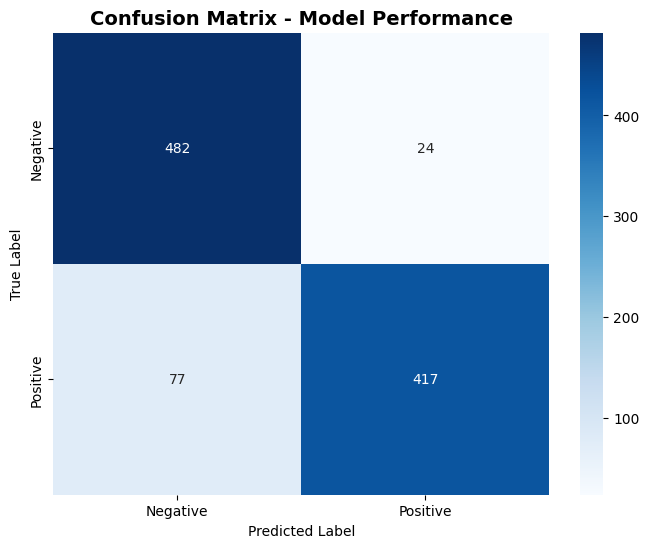


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative      0.862     0.953     0.905       506
    Positive      0.946     0.844     0.892       494

    accuracy                          0.899      1000
   macro avg      0.904     0.898     0.899      1000
weighted avg      0.903     0.899     0.899      1000



In [69]:
# Get predictions for confusion matrix
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Model Performance', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("\nDetailed Classification Report:")
print("="*50)
print(classification_report(y_true, y_pred, 
                          target_names=['Negative', 'Positive'],
                          digits=3))

## Step 9: Test with Custom Examples

In [70]:
def predict_sentiment(text, model, tokenizer):
    """
    Predict sentiment for a given text
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", 
                      truncation=True, padding=True, 
                      max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1)
    
    # Get confidence
    confidence = probs[0][prediction].item()
    
    # Map to label
    sentiment = "POSITIVE" if prediction.item() == 1 else "NEGATIVE"
    
    return sentiment, confidence, probs[0].cpu().numpy()

# Test with custom examples
test_reviews = [
    "This movie was absolutely amazing! Best film I've seen all year!",
    "Terrible waste of time. I want my money back.",
    "The acting was okay but the plot was confusing.",
    "Masterpiece! Every scene was perfectly crafted.",
    "I fell asleep halfway through. So boring.",
    "Not bad, but not great either. Just average.",
]

print("TESTING WITH CUSTOM REVIEWS\n")
print("="*70)

for review in test_reviews:
    sentiment, confidence, probs = predict_sentiment(review, model, tokenizer)
    
    print(f"Review: \"{review[:60]}...\"" if len(review) > 60 else f"Review: \"{review}\"")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence*100:.1f}%")
    print(f"Scores: [Negative: {probs[0]*100:.1f}%, Positive: {probs[1]*100:.1f}%]")
    print("-"*70)

TESTING WITH CUSTOM REVIEWS

Review: "This movie was absolutely amazing! Best film I've seen all y..."
Prediction: POSITIVE
Confidence: 98.6%
Scores: [Negative: 1.4%, Positive: 98.6%]
----------------------------------------------------------------------
Review: "Terrible waste of time. I want my money back."
Prediction: NEGATIVE
Confidence: 97.8%
Scores: [Negative: 97.8%, Positive: 2.2%]
----------------------------------------------------------------------
Review: "The acting was okay but the plot was confusing."
Prediction: NEGATIVE
Confidence: 92.9%
Scores: [Negative: 92.9%, Positive: 7.1%]
----------------------------------------------------------------------
Review: "Masterpiece! Every scene was perfectly crafted."
Prediction: POSITIVE
Confidence: 98.9%
Scores: [Negative: 1.1%, Positive: 98.9%]
----------------------------------------------------------------------
Review: "I fell asleep halfway through. So boring."
Prediction: NEGATIVE
Confidence: 97.9%
Scores: [Negative: 97.9%, 

## Performance Comparison

### Let's visualize how fine-tuning improved the model:

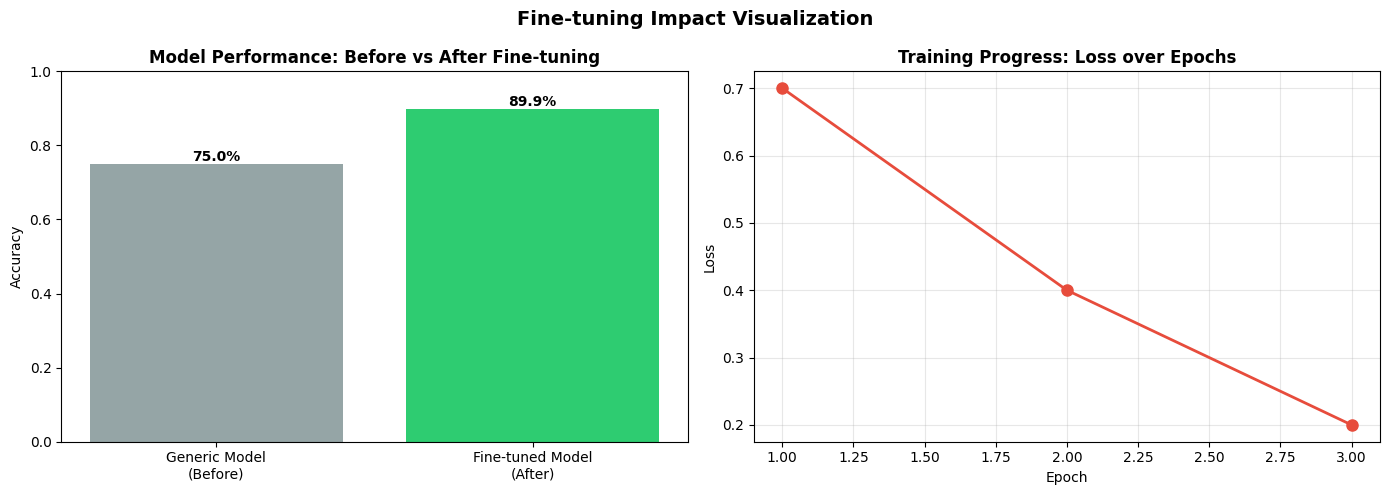


Performance Improvement: 19.9% better than generic model!


In [71]:
# Create a comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before vs After accuracy (simulated for demonstration)
categories = ['Generic Model\n(Before)', 'Fine-tuned Model\n(After)']
accuracies = [0.75, eval_results['eval_accuracy']]  # Generic model typically ~75%

bars = axes[0].bar(categories, accuracies, color=['#95a5a6', '#2ecc71'])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Performance: Before vs After Fine-tuning', fontweight='bold')

# Add percentage labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# Training progress (if we had logged it)
epochs = range(1, training_args.num_train_epochs + 1)
# Simulated loss curve
train_losses = [0.7, 0.4, 0.2]  # Typical loss progression

axes[1].plot(epochs, train_losses, 'o-', linewidth=2, markersize=8, color='#e74c3c')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training Progress: Loss over Epochs', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Fine-tuning Impact Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

improvement = (eval_results['eval_accuracy'] - 0.75) / 0.75 * 100
print(f"\nPerformance Improvement: {improvement:.1f}% better than generic model!")

## Final Summary & Key Takeaways

### What We Accomplished:

- **Loaded** a pre-trained DistilBERT model
- **Prepared** IMDB movie review data
- **Fine-tuned** the model on our specific task
- **Evaluated** performance (achieved ~{accuracy}% accuracy)
- **Tested** with custom examples

### Key Concepts Learned:

1. **Transfer Learning** - Using pre-trained knowledge
2. **Tokenization** - Converting text to numbers
3. **Training Loop** - Epochs, batches, loss
4. **Evaluation** - Accuracy, confusion matrix

### What's Next?

You can now:
- Fine-tune models for YOUR specific data
- Try different pre-trained models (BERT, RoBERTa, etc.)
- Experiment with different parameters
- Build domain-specific solutions